<a href="https://colab.research.google.com/github/HarishBankai/FY-PPS/blob/main/LAB10_FDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DATA SAMPLE
        date region       outlet  price  promo  copies_sold  returns  delivery_delay_mins  net_sales  week    month
0 2024-01-01  North  NO_Outlet_1    1.3      0          227        7                   35      295.1     1  2024-01
1 2024-01-02  North  NO_Outlet_1    1.3      0          184        3                   22      239.2     1  2024-01
2 2024-01-03  North  NO_Outlet_1    1.3      0          221       13                   24      287.3     1  2024-01
3 2024-01-04  North  NO_Outlet_1    1.3      0          221        7                   22      287.3     1  2024-01
4 2024-01-05  North  NO_Outlet_1    1.3      0          225        7                   20      292.5     1  2024-01
5 2024-01-06  North  NO_Outlet_1    1.3      1          202        9                   24      262.6     1  2024-01
6 2024-01-07  North  NO_Outlet_1    1.3      0          124        1                   33      161.2     1  2024-01
7 2024-01-08  North  NO_Outlet_1    1.3      0          237 

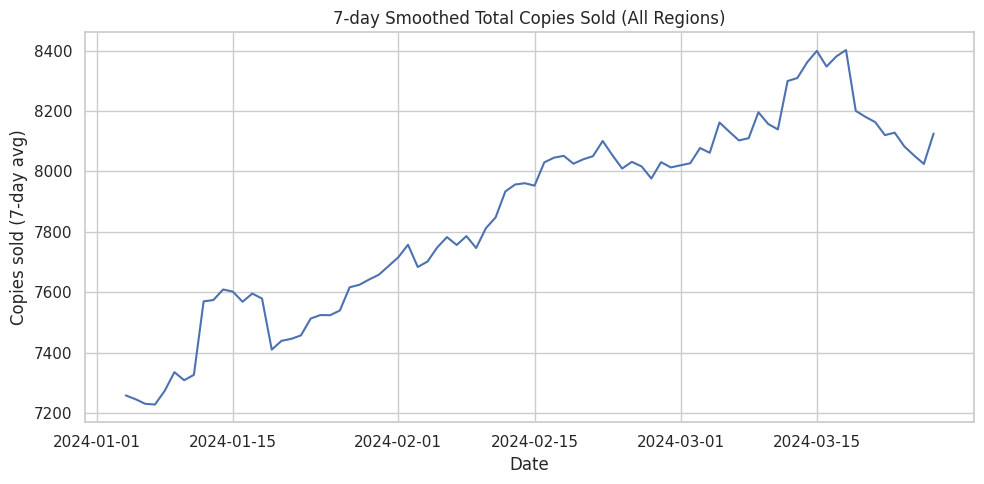

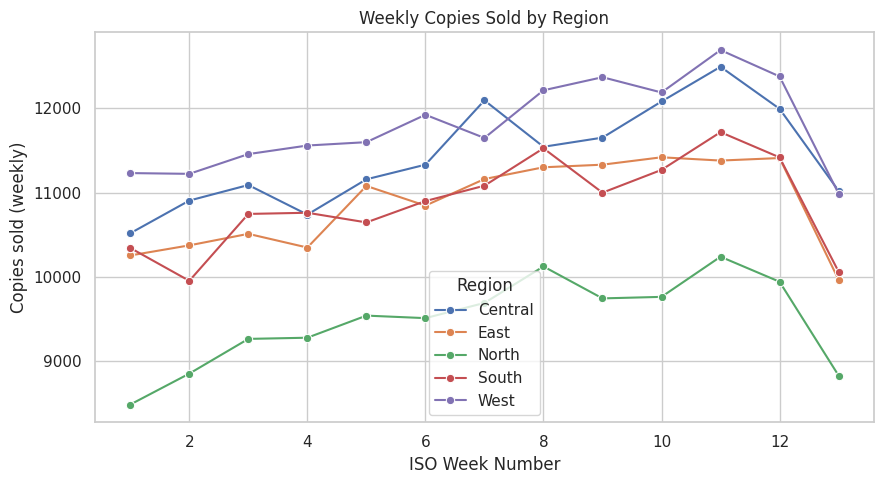

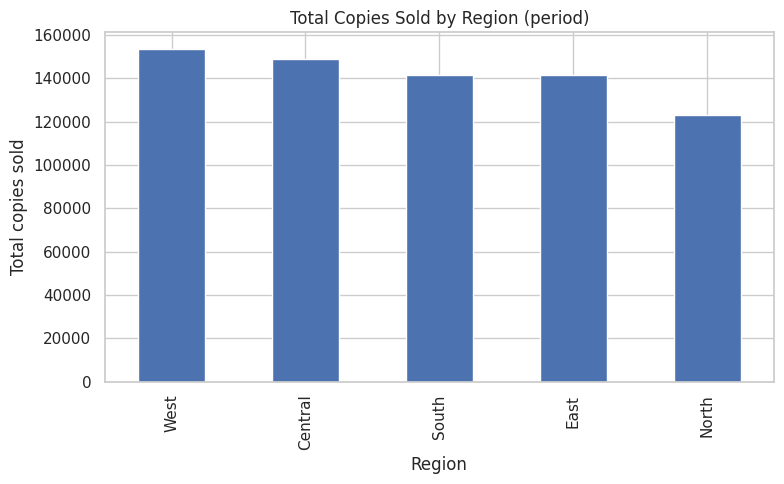

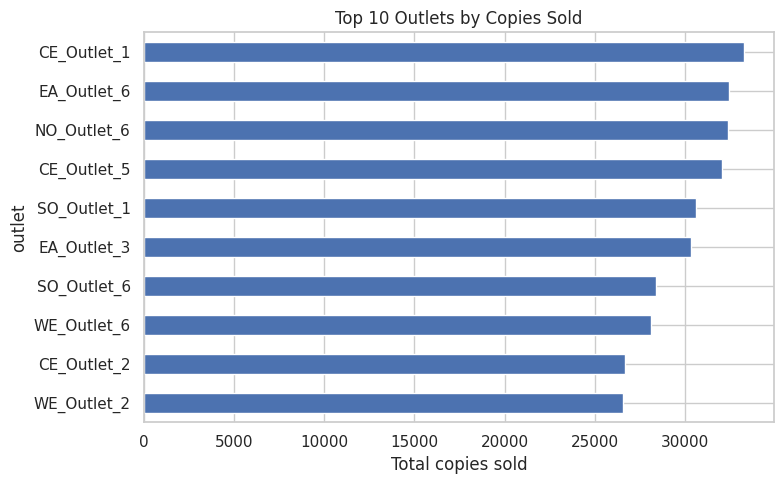

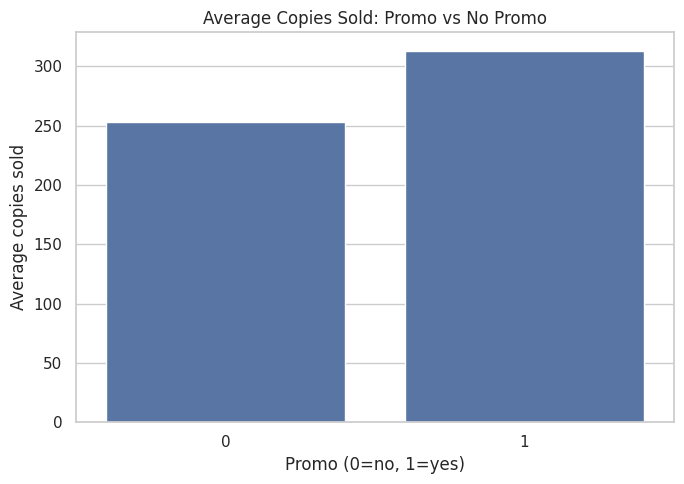

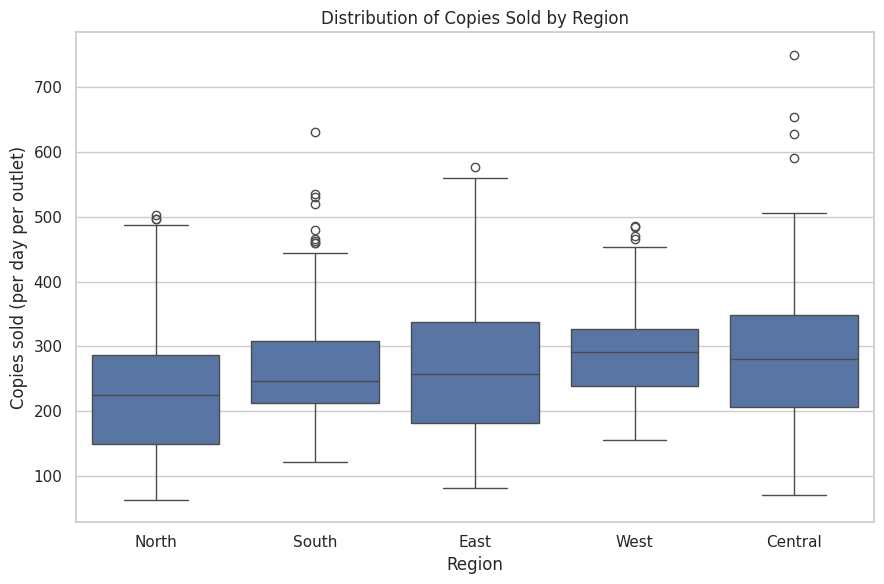

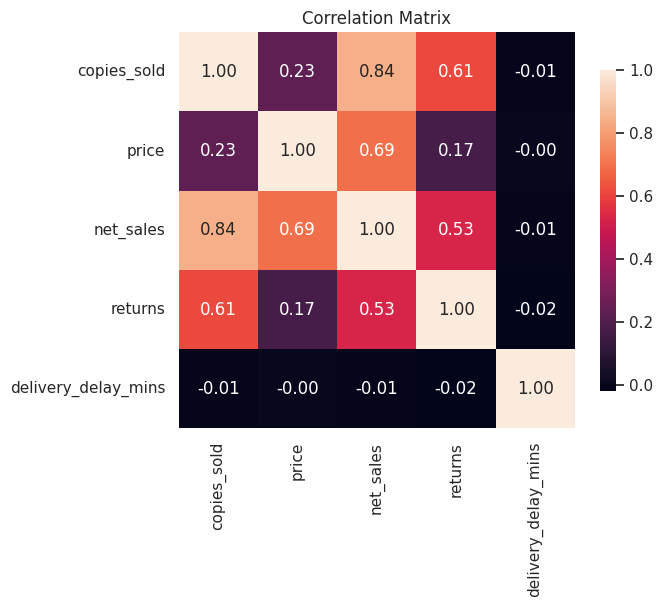

<Figure size 1000x500 with 0 Axes>

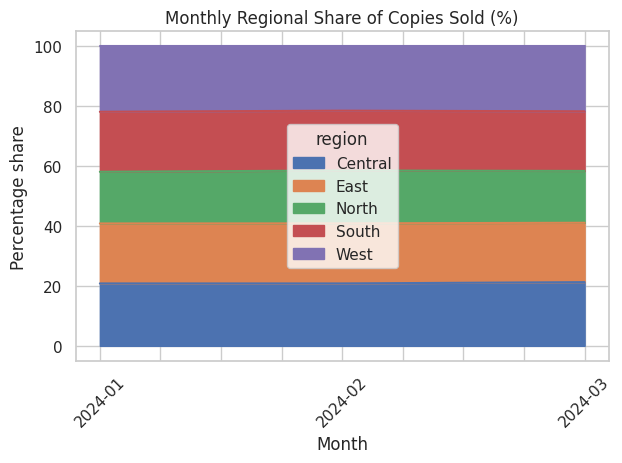


TOP 8 OUTLET STATS
         outlet  copies_sold  net_sales  returns  delivery_delay_mins  return_rate_pct
0   CE_Outlet_1        33279   48254.55     1139            24.344444         3.422579
11  EA_Outlet_6        32461   28241.07     1096            24.433333         3.376359
17  NO_Outlet_6        32391   37573.56     1119            24.788889         3.454663
4   CE_Outlet_5        32055   39107.10     1093            23.711111         3.409764
18  SO_Outlet_1        30636   38601.36     1046            25.366667         3.414284
8   EA_Outlet_3        30326   32752.08     1007            25.111111         3.320583
23  SO_Outlet_6        28385   39455.15      972            25.788889         3.424344
29  WE_Outlet_6        28103   32037.42      942            25.933333         3.351955


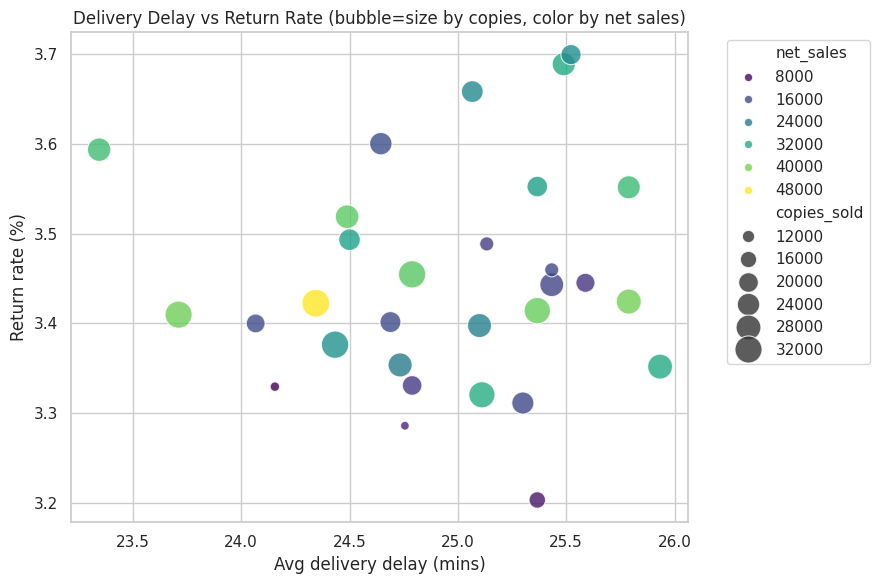


OUTLET CLUSTER COUNTS
cluster
2    13
1    11
0     6
Name: count, dtype: int64


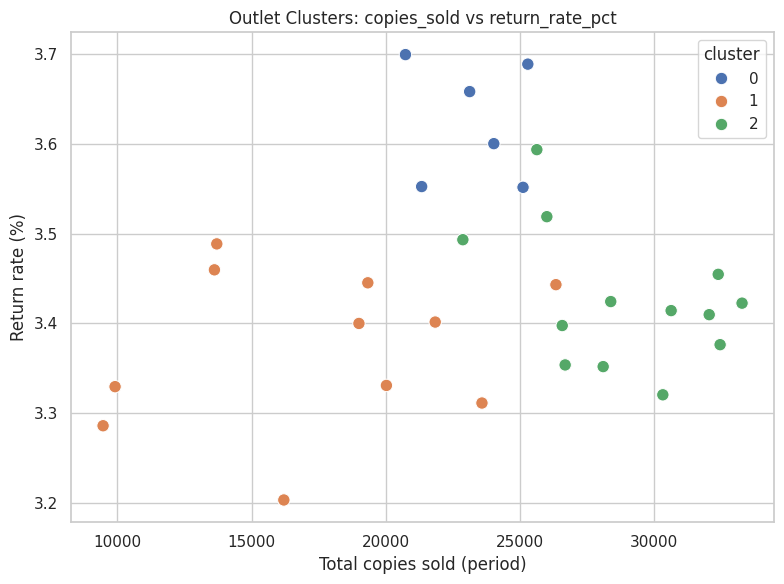


KEY METRICS
overall_total_copies: 708058
overall_net_sales: 765014.1699999999
avg_daily_copies: 7867.311111111111
avg_return_rate_pct: 3.4498586274005802


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reproducible
np.random.seed(42)

# Timeline & structure
dates = pd.date_range(start="2024-01-01", periods=90, freq="D")
regions = ["North", "South", "East", "West", "Central"]
outlets_per_region = 6

rows = []
for region in regions:
    for i in range(outlets_per_region):
        # create outlet-specific parameters
        outlet = f"{region[:2].upper()}_Outlet_{i+1}"
        base_demand = np.random.randint(80, 300)          # base daily demand per outlet
        price = round(np.random.uniform(0.5, 1.5), 2)     # price per copy for this outlet

        # simulate for each date for this outlet
        for d in dates:
            # seasonality (annual), weekday effect, promo, occasional special event
            seasonal = 1 + 0.15 * np.sin(2 * np.pi * (d.dayofyear / 365))
            weekday_effect = 1.2 if d.weekday() < 5 else 0.8
            promo = np.random.choice([0, 1], p=[0.85, 0.15])
            promo_boost = 1.25 if promo == 1 else 1.0
            special_event = 1.5 if (d.day % 15 == 0 and np.random.rand() < 0.2) else 1.0

            # generate copies sold (with some noise)
            copies = int(np.round(base_demand * seasonal * weekday_effect * promo_boost *
                                 special_event * np.random.normal(1, 0.08)))
            copies = max(0, copies)  # ensure non-negative

            # returns, delivery delay
            returns = int(max(0, np.round(copies * np.random.uniform(0.01, 0.06))))
            delivery_delay_mins = int(np.round(np.random.normal(25, 7)))
            delivery_delay_mins = max(0, delivery_delay_mins)

            rows.append({
                "date": d,
                "region": region,
                "outlet": outlet,
                "price": price,
                "promo": promo,
                "copies_sold": copies,
                "returns": returns,
                "delivery_delay_mins": delivery_delay_mins
            })

# build DataFrame and derived columns
df = pd.DataFrame(rows)
df["net_sales"] = df["copies_sold"] * df["price"]
df["week"] = df["date"].dt.isocalendar().week
df["month"] = df["date"].dt.to_period("M").astype(str)

pd.set_option("display.width", 140)
print("DATA SAMPLE")
print(df.head(8))

print("\nSUMMARY")
print(df[["copies_sold", "price", "net_sales", "returns", "delivery_delay_mins"]].describe().T)

# plotting theme
sns.set_theme(style="whitegrid")

# 1) 7-day smoothed daily total copies sold
plt.figure(figsize=(10, 5))
daily = df.groupby("date")["copies_sold"].sum().rolling(7, center=True).mean()
plt.plot(daily.index, daily.values)
plt.title("7-day Smoothed Total Copies Sold (All Regions)")
plt.xlabel("Date")
plt.ylabel("Copies sold (7-day avg)")
plt.tight_layout()
plt.show()

# 2) Weekly copies sold by region
plt.figure(figsize=(9, 5))
region_weekly = df.groupby(["region", "week"])["copies_sold"].sum().reset_index()
sns.lineplot(data=region_weekly, x="week", y="copies_sold", hue="region", marker="o")
plt.title("Weekly Copies Sold by Region")
plt.xlabel("ISO Week Number")
plt.ylabel("Copies sold (weekly)")
plt.legend(title="Region")
plt.tight_layout()
plt.show()

# 3) Total copies sold by region
plt.figure(figsize=(8, 5))
region_total = df.groupby("region")["copies_sold"].sum().sort_values(ascending=False)
region_total.plot(kind="bar")
plt.title("Total Copies Sold by Region (period)")
plt.xlabel("Region")
plt.ylabel("Total copies sold")
plt.tight_layout()
plt.show()

# 4) Top 10 outlets by copies sold
plt.figure(figsize=(8, 5))
top_outlets = df.groupby("outlet")["copies_sold"].sum().nlargest(10).sort_values()
top_outlets.plot(kind="barh")
plt.title("Top 10 Outlets by Copies Sold")
plt.xlabel("Total copies sold")
plt.tight_layout()
plt.show()

# 5) Promo effect (avg copies sold)
plt.figure(figsize=(7, 5))
promo_effect = df.groupby("promo")["copies_sold"].mean().reset_index()
sns.barplot(data=promo_effect, x="promo", y="copies_sold")
plt.title("Average Copies Sold: Promo vs No Promo")
plt.xlabel("Promo (0=no, 1=yes)")
plt.ylabel("Average copies sold")
plt.tight_layout()
plt.show()

# 6) Boxplot: distribution by region
plt.figure(figsize=(9, 6))
sns.boxplot(data=df, x="region", y="copies_sold")
plt.title("Distribution of Copies Sold by Region")
plt.xlabel("Region")
plt.ylabel("Copies sold (per day per outlet)")
plt.tight_layout()
plt.show()

# 7) Correlation heatmap
plt.figure(figsize=(7, 6))
corr = df[["copies_sold", "price", "net_sales", "returns", "delivery_delay_mins"]].corr()
sns.heatmap(corr, annot=True, fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# 8) Monthly regional share (stacked area %)
pivot = pd.pivot_table(df, index="month", columns="region", values="copies_sold", aggfunc="sum")
pivot_pct = pivot.div(pivot.sum(axis=1), axis=0) * 100
plt.figure(figsize=(10, 5))
pivot_pct.plot(kind="area", stacked=True, legend=True)
plt.title("Monthly Regional Share of Copies Sold (%)")
plt.xlabel("Month")
plt.ylabel("Percentage share")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# outlet-level stats & scatter bubble plot
outlet_stats = df.groupby("outlet").agg({
    "copies_sold": "sum",
    "net_sales": "sum",
    "returns": "sum",
    "delivery_delay_mins": "mean"
}).reset_index()
outlet_stats["return_rate_pct"] = outlet_stats["returns"] / outlet_stats["copies_sold"] * 100
outlet_stats = outlet_stats.sort_values("copies_sold", ascending=False)

print("\nTOP 8 OUTLET STATS")
print(outlet_stats.head(8))

plt.figure(figsize=(9, 6))
sns.scatterplot(data=outlet_stats.head(40),
                x="delivery_delay_mins", y="return_rate_pct",
                size="copies_sold", hue="net_sales", alpha=0.8, sizes=(40, 400), palette="viridis")
plt.title("Delivery Delay vs Return Rate (bubble=size by copies, color by net sales)")
plt.xlabel("Avg delivery delay (mins)")
plt.ylabel("Return rate (%)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.tight_layout()
plt.show()

# Clustering (KMeans)
from sklearn.cluster import KMeans
clust_df = outlet_stats[["copies_sold", "net_sales", "delivery_delay_mins", "return_rate_pct"]].copy()
clust_df_scaled = (clust_df - clust_df.mean()) / clust_df.std()
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10).fit(clust_df_scaled)
outlet_stats["cluster"] = kmeans.labels_

print("\nOUTLET CLUSTER COUNTS")
print(outlet_stats["cluster"].value_counts())

plt.figure(figsize=(8, 6))
sns.scatterplot(data=outlet_stats, x="copies_sold", y="return_rate_pct", hue="cluster", palette="deep", s=80)
plt.title("Outlet Clusters: copies_sold vs return_rate_pct")
plt.xlabel("Total copies sold (period)")
plt.ylabel("Return rate (%)")
plt.tight_layout()
plt.show()

# Key metrics summary
summary = {
    "overall_total_copies": int(df["copies_sold"].sum()),
    "overall_net_sales": float(df["net_sales"].sum()),
    "avg_daily_copies": float(df.groupby("date")["copies_sold"].sum().mean()),
    "avg_return_rate_pct": float(df["returns"].sum() / df["copies_sold"].sum() * 100)
}

print("\nKEY METRICS")
for k, v in summary.items():
    print(f"{k}: {v}")
